# Imports

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Data Cleaning

In [34]:
def convert_to_weeks(value):
    try:
        value = str(value).lower()
        num = float(value.split()[0])
        if 'week' in value:
            return num
        elif 'month' in value:
            return num * 4.345
        elif 'year' in value:
            return num * 52.1775
        elif 'day' in value:
            return num / 7.0
        else:
            return 0.0
    except Exception:
        return 0.0


def extract_month_year(df, column='Intake Time'):
    def normalize_date(date_str):
        date_str = date_str.split(' ')[0]
        date_parts = date_str.split('/')
        month = int(date_parts[0])
        year = int(date_parts[2])
        if year < 100:
            year += 2000
        return month, year

    df[['Intake Month', 'Intake Year']] = df[column].apply(
        lambda x: pd.Series(normalize_date(str(x))))
    return df


def add_minutes_since_midnight(df):
    minutes_since_midnight = []
    for time_str in df['Intake Time']:
        if isinstance(time_str, str) and time_str.strip():
            parts = time_str.split(' ')
            if len(parts) < 2:
                minutes_since_midnight.append(0)
                continue
            time_str = ' '.join(parts[1:])
            try:
                if 'AM' in time_str or 'PM' in time_str:
                    time_obj = datetime.strptime(time_str, '%I:%M:%S %p')
                else:
                    time_obj = datetime.strptime(time_str, '%H:%M:%S')
            except ValueError:
                try:
                    time_obj = datetime.strptime(time_str, '%I:%M %p')
                except ValueError:
                    time_obj = datetime.strptime(time_str, '%H:%M')
            minutes = time_obj.hour * 60 + time_obj.minute
            minutes_since_midnight.append(minutes)
        else:
            minutes_since_midnight.append(0)
    df['Minutes Since Midnight'] = minutes_since_midnight
    return df


def extract_city_from_address(df):
    def extract_city(address):
        tokens = address.split()
        if '(TX)' in tokens:
            idx = tokens.index('(TX)') - 1
            return tokens[idx] if idx >= 0 else 'Unknown'
        return 'Unknown'

    df['City'] = df['Found Location'].apply(extract_city)
    return df


def drop_columns(df, columns=None):
    if columns is None:
        columns = ['Id', 'Name', 'Outcome Time', 'Date of Birth',
                   'Intake Time', 'Found Location']
    df = df.drop(columns=columns, errors='ignore')
    # df = df.drop(columns=['Breed', 'Color'], errors='ignore')
    df = df.dropna()
    return df


def standardize_features(df):
    df = extract_city_from_address(df)
    df['Age upon Intake'] = df['Age upon Intake'].apply(convert_to_weeks)
    df['Age upon Intake'] = pd.to_numeric(
        df['Age upon Intake'], errors='coerce').fillna(0.0)
    df = extract_month_year(df, column='Intake Time')
    return df


def rare_hot_encode_features(df, columns=None, rare_threshold=0.01):
    if columns is None:
        columns = ['Intake Condition', 'Intake Type', 'Animal Type',
                   'Sex upon Intake', 'City', 'Breed', 'Color']
    for col in columns:
        if col in df.columns:
            freq = df[col].value_counts() / len(df)
            rare_values = freq[freq < rare_threshold].index
            df[col] = df[col].replace(rare_values, 'Rare')
    existing_columns = [col for col in columns if col in df.columns]
    df = pd.get_dummies(df, columns=existing_columns)
    return df


def frequency_encode_features(df, columns=None):
    if columns is None:
        columns = ['Breed', 'Color', 'City']
    for col in columns:
        if col in df.columns:
            df[f'{col}_frequency'] = df[col].map(
                df[col].value_counts(normalize=True))
    return df


# Feature Engineering

In [10]:
def add_intake_weekday(df):
    df['Intake Weekday'] = df['Intake Time'].apply(
        lambda x: pd.to_datetime(x.split(' ')[0], errors='coerce').dayofweek if isinstance(x, str) else None)
    return df


def add_color_count(df):
    df['Num Colors'] = df['Color'].apply(lambda x: len(str(x).split('/')))
    return df


def process_breeds_colors(df):
    breeds = df['Breed'].str.split('/', n=1, expand=True).fillna('None')
    df['Breed 1'] = breeds.apply(lambda row: min(row[0], row[1]), axis=1)
    df['Breed 2'] = breeds.apply(lambda row: max(row[0], row[1]), axis=1)

    colors = df['Color'].str.split('/', n=1, expand=True).fillna('None')
    df['Color 1'] = colors.apply(lambda row: min(row[0], row[1]), axis=1)
    df['Color 2'] = colors.apply(lambda row: max(row[0], row[1]), axis=1)

    return df


def add_age_ratio_feature(df):
    avg_age_by_type = df.groupby('Animal Type')['Age upon Intake'].mean()
    breed_freq = df['Breed'].value_counts(normalize=True)
    avg_age_by_breed = df.groupby('Breed')['Age upon Intake'].mean()

    def get_age_ratio(row):
        if breed_freq.get(row['Breed'], 0) > 0.01:
            avg_age = avg_age_by_breed.get(
                row['Breed'], avg_age_by_type[row['Animal Type']])
        else:
            avg_age = avg_age_by_type[row['Animal Type']]
        return row['Age upon Intake'] / avg_age

    df['Age upon Intake Ratio'] = df.apply(get_age_ratio, axis=1)
    return df


def add_relative_age_feature_from_data(df, min_freq=0.01):
    breed_freq = df['Breed'].value_counts(normalize=True)
    frequent_breeds = breed_freq[breed_freq > min_freq].index
    max_age_by_breed = df[df['Breed'].isin(
        frequent_breeds)].groupby('Breed')['Age upon Intake'].max()
    avg_max_age_by_type = df.groupby(
        'Animal Type')['Age upon Intake'].max()

    def compute_relative_age(row):
        breed = row['Breed']
        animal_type = row['Animal Type']
        max_age = max_age_by_breed.get(
            breed, avg_max_age_by_type.get(animal_type, 1))
        return 0 if max_age == 0 else row['Age upon Intake'] / max_age

    df['Relative Age'] = df.apply(compute_relative_age, axis=1)
    return df


def engineer_features(df):
    df = add_intake_weekday(df)
    df = add_color_count(df)
    # df = process_breeds_colors(df)
    df = add_minutes_since_midnight(df)
    df = add_age_ratio_feature(df)
    df = add_relative_age_feature_from_data(df)
    return df


def scale_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df


# Data Exploration

In [ ]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Basic shape & preview
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

# Missing values per column
print("Missing values in train:")
print(train_df.isnull().sum())

print("\nMissing values in test:")
print(test_df.isnull().sum())


# Data types
print("Train dtypes:\n", train_df.dtypes)

# Summary stats for numerical columns
print(train_df.describe())



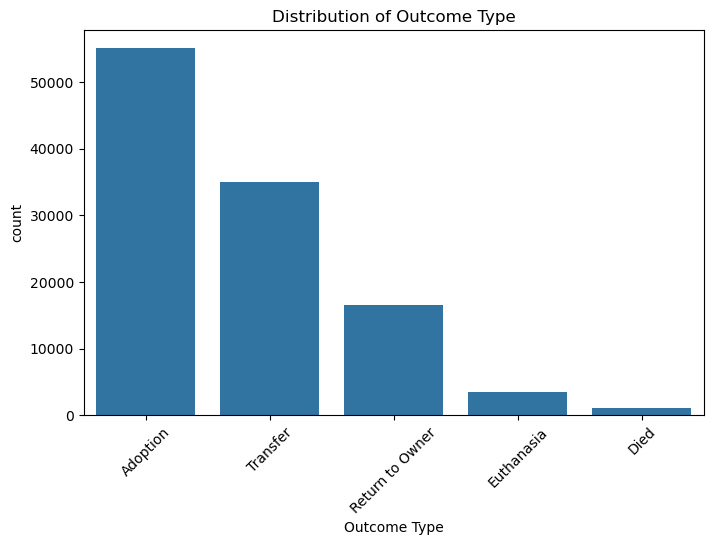

In [26]:
# Check distribution of target variable
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='Outcome Type', order=train_df['Outcome Type'].value_counts().index)
plt.title('Distribution of Outcome Type')
plt.xticks(rotation=45)
plt.show()


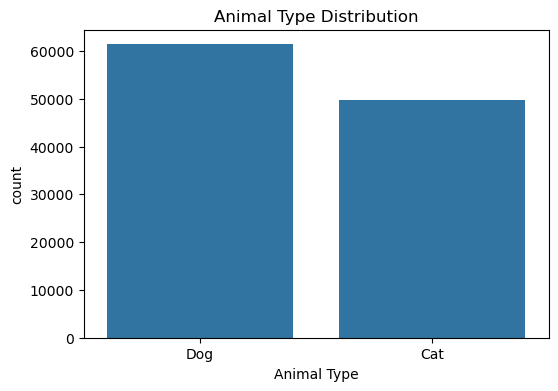

In [23]:
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='Animal Type')
plt.title('Animal Type Distribution')
plt.show()


In [ ]:
# Most common colors
print(train_df['Color'].value_counts().head(10))

# Most common breeds
print(train_df['Breed'].value_counts().head(10))


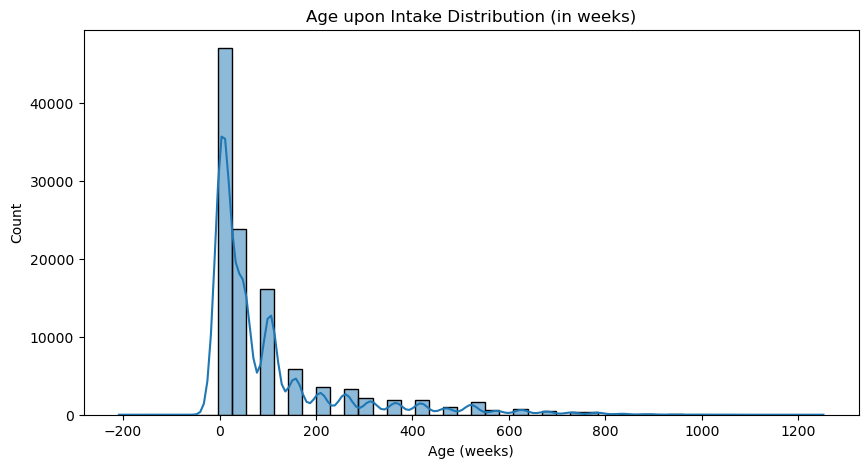

In [25]:
train_df['Age upon Intake (weeks)'] = train_df['Age upon Intake'].apply(convert_to_weeks)

plt.figure(figsize=(10, 5))
sns.histplot(train_df['Age upon Intake (weeks)'].dropna(), bins=50, kde=True)
plt.title('Age upon Intake Distribution (in weeks)')
plt.xlabel('Age (weeks)')
plt.show()


In [32]:
def clean(df):
    df = standardize_features(df)
    df = engineer_features(df)
    df = frequency_encode_features(df)
    # df = rare_hot_encode_features(df)
    df = drop_columns(df)
    # df = scale_features(df)
    return df
    

In [35]:
train_data = pd.read_csv('train.csv').head(50)
clean(train_data).head()

,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Outcome Type,City,Intake Month,Intake Year,Intake Weekday,Num Colors,Minutes Since Midnight,Age upon Intake Ratio,Relative Age,Breed_frequency,Color_frequency,City_frequency
0,Stray,Normal,Dog,Spayed Female,417.420,English Springer Spaniel,White/Liver,Return to Owner,Austin,7,2015,6,2,779,1.000000,1.0,0.02,0.02,0.88
1,Stray,Normal,Dog,Intact Male,47.795,Basenji Mix,Sable/White,Return to Owner,Austin,4,2016,3,2,1123,1.000000,1.0,0.02,0.02,0.88
2,Public Assist,Normal,Cat,Neutered Male,104.355,Domestic Shorthair,Orange Tabby,Transfer,Austin,5,2022,3,1,23,2.889753,1.0,0.12,0.04,0.88
3,Owner Surrender,Normal,Dog,Neutered Male,104.355,Labrador Retriever Mix,Chocolate,Return to Owner,Austin,2,2017,5,1,766,1.600046,1.0,0.10,0.02,0.88
4,Public Assist,Normal,Dog,Neutered Male,313.065,Great Dane Mix,Black,Return to Owner,Austin,4,2019,1,1,593,1.000000,1.0,0.02,0.12,0.88


# Models

### CatBoost

In [ ]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score

# Load data
train_data = pd.read_csv('train.csv').dropna()

# Process and clean
# train_data = process_breeds_colors(train_data)  # Your preprocessing function for breeds and colors

# Split features and target
X = train_data.drop(columns=['Outcome Type'])
y = train_data['Outcome Type']

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Clean (your preprocessing function)
X_train = clean(X_train)
X_val = clean(X_val)

# Align columns
X_val = X_val.reindex(columns=X_train.columns, fill_value=False)

# Label encoding for target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# Categorical feature names
cat_feature_names = ['Intake Type', 'Intake Condition', 'Animal Type', 
                     'Sex upon Intake', 'Breed', 'Color', 'City']

# Get indices of categorical features
cat_features = [i for i, col in enumerate(X_train.columns) if col in cat_feature_names]

# Initialize CatBoost model
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.02,
    depth=8,
    loss_function='MultiClass',
    auto_class_weights='Balanced',
    verbose=0,
    random_seed=42
)

# Train the model with explicit categorical feature indices
cat_model.fit(X_train, y_train_enc, cat_features=cat_features)

# Predict and evaluate
y_pred = cat_model.predict(X_val).flatten().astype(int)

balanced_acc = balanced_accuracy_score(y_val_enc, y_pred)
print(f'CatBoost Balanced Accuracy: {balanced_acc:.4f}')


In [47]:
# Load test data
test_data = pd.read_csv('test.csv')

# Clean test data
X_test = clean(test_data)

# Align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=False)

# Predict with trained CatBoost model
test_preds_enc = cat_model.predict(X_test).flatten().astype(int)

# Decode numeric predictions back to original labels
test_preds = le.inverse_transform(test_preds_enc)

# Prepare final DataFrame with sequential Ids starting at 1
output_df = pd.DataFrame({
    'Id': range(1, len(test_data) + 1),
    'Outcome Type': test_preds
})

# Save to CSV
output_df.to_csv('cat.csv', index=False)

print("Predictions saved to cat.csv")


Predictions saved to cat.csv


                   Feature  Importance
0              Intake Type   15.507560
7                  Color 1   15.250016
3          Sex upon Intake   12.009828
8                  Color 2   11.059823
6                  Breed 2    9.302343
9                     City    6.003693
1         Intake Condition    5.966677
14            Relative Age    4.153379
5                  Breed 1    3.889315
2              Animal Type    3.103511
4          Age upon Intake    2.692140
10            Intake Month    2.671244
15         Breed_frequency    2.470930
13  Minutes Since Midnight    2.161589
16         Color_frequency    1.837664
11             Intake Year    0.867144
12          Intake Weekday    0.832043
17          City_frequency    0.221099


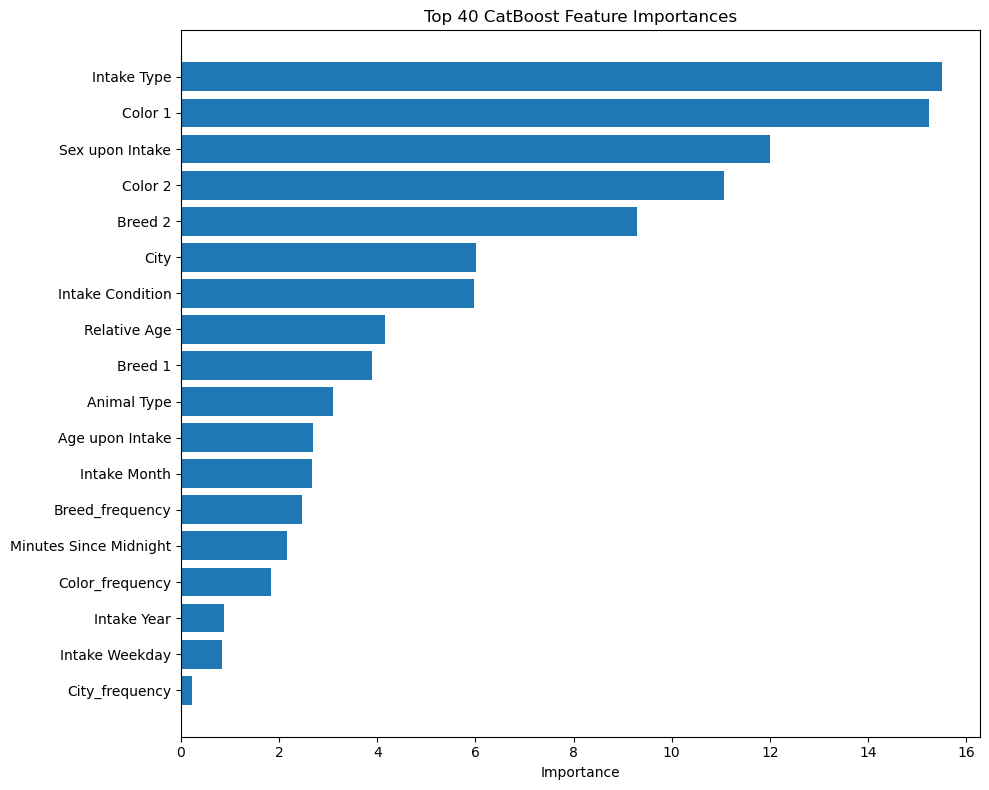

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = cat_model.get_feature_importance()
feature_names = X_train.columns

# Create DataFrame for nicer handling
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance descending
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Display top 40
print(feat_imp_df.head(40))

# Optional: Plot top 40
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df.head(40)['Feature'][::-1], feat_imp_df.head(40)['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 40 CatBoost Feature Importances')
plt.tight_layout()
plt.show()


### LightGBM (Used in final predictions)

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import balanced_accuracy_score
from scipy.stats import uniform, randint
from collections import Counter  # Add this for counting

# Load data
train_data = pd.read_csv('train.csv')
train_data = train_data.dropna()

X = train_data.drop(columns=['Outcome Type'])
y = train_data['Outcome Type']

# Split into train/val sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Clean them (MUST COM
X_train = clean(X_train)
X_val = clean(X_val)
X_val = X_val.reindex(columns=X_train.columns, fill_value=False)

# Label encoding for target since LightGBM needs numeric labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# Base model
lgb_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    metric='multi_logloss',
    verbose=-1,
    random_state=42,
    class_weight='balanced'
)

# Parameter distributions
param_dist = {
    'learning_rate': uniform(0.01, 0.09),    # 0.01 to 0.1
    'num_leaves': randint(15, 63),
    'max_depth': [-1, 10, 20],
    'min_child_samples': randint(10, 30),
    'n_estimators': randint(100, 300)
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    scoring='balanced_accuracy',
    n_iter=1,          # total runs — you can lower this if needed
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit random search
random_search.fit(X_train, y_train_enc)

# Best parameters
print("Best parameters found:")
print(random_search.best_params_)

# Best model
best_lgb = random_search.best_estimator_

# Predict with best model
y_pred = best_lgb.predict(X_val)

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_val_enc, y_pred)
print(f'Best LightGBM Balanced Accuracy: {balanced_acc:.4f}')

# Print the number of each predicted class
prediction_counts = Counter(y_pred)
print("Prediction counts:")
for label, count in prediction_counts.items():
    print(f"Class {le.inverse_transform([label])[0]}: {count}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits


ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\troyn\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\troyn\miniconda3\envs\ml\lib\site-packages\lightgbm\sklearn.py", line 1560, in fit
    super().fit(
  File "C:\Users\troyn\miniconda3\envs\ml\lib\site-packages\lightgbm\sklearn.py", line 1049, in fit
    self._Booster = train(
  File "C:\Users\troyn\miniconda3\envs\ml\lib\site-packages\lightgbm\engine.py", line 297, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\troyn\miniconda3\envs\ml\lib\site-packages\lightgbm\basic.py", line 3656, in __init__
    train_set.construct()
  File "C:\Users\troyn\miniconda3\envs\ml\lib\site-packages\lightgbm\basic.py", line 2590, in construct
    self._lazy_init(
  File "C:\Users\troyn\miniconda3\envs\ml\lib\site-packages\lightgbm\basic.py", line 2123, in _lazy_init
    data, feature_name, categorical_feature, self.pandas_categorical = _data_from_pandas(
  File "C:\Users\troyn\miniconda3\envs\ml\lib\site-packages\lightgbm\basic.py", line 868, in _data_from_pandas
    _pandas_to_numpy(data, target_dtype=target_dtype),
  File "C:\Users\troyn\miniconda3\envs\ml\lib\site-packages\lightgbm\basic.py", line 814, in _pandas_to_numpy
    _check_for_bad_pandas_dtypes(data.dtypes)
  File "C:\Users\troyn\miniconda3\envs\ml\lib\site-packages\lightgbm\basic.py", line 805, in _check_for_bad_pandas_dtypes
    raise ValueError(
ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: Intake Type: object, Intake Condition: object, Animal Type: object, Sex upon Intake: object, Breed: object, Color: object, City: object


Best LightGBM Balanced Accuracy: 0.4807
Prediction counts:
Class Adoption: 5424
Class Died: 1263
Class Transfer: 2893
Class Return to Owner: 4693
Class Euthanasia: 1682


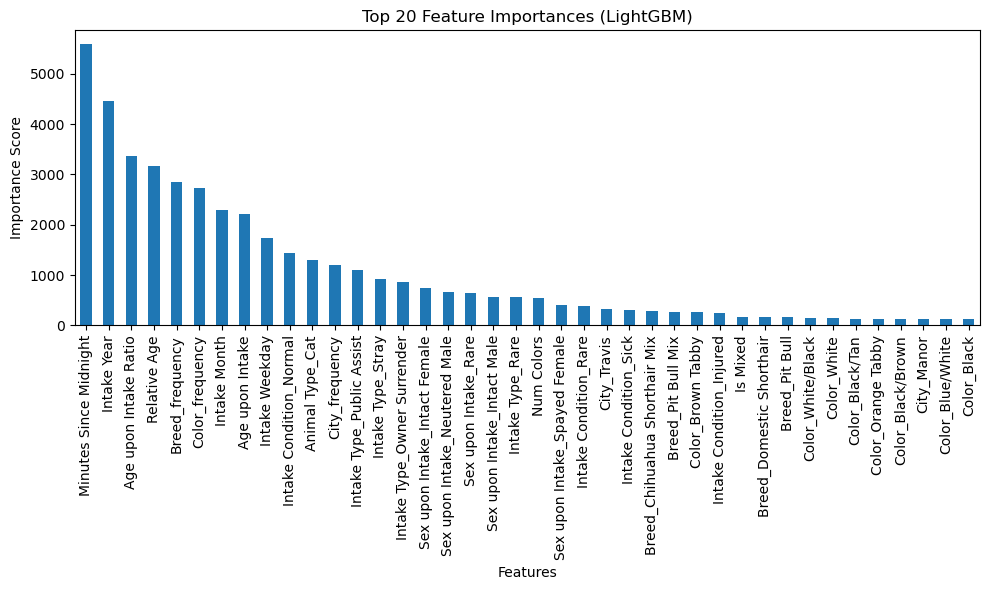

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import balanced_accuracy_score
from collections import Counter
import matplotlib.pyplot as plt

# Load data
train_data = pd.read_csv('train.csv')
train_data = train_data.dropna()

X = train_data.drop(columns=['Outcome Type'])
y = train_data['Outcome Type']

# Split into train/val sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Clean them (your custom function)
X_train = clean(X_train)
X_val = clean(X_val)
X_val = X_val.reindex(columns=X_train.columns, fill_value=False)

# Label encoding for target since LightGBM needs numeric labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# Initialize LGBMClassifier with the best parameters found
lgb_model = LGBMClassifier(
    learning_rate=0.010635967469774566,
    max_depth=-1,
    min_child_samples=26,
    n_estimators=158,
    num_leaves=56,
    objective='multiclass',
    num_class=len(le.classes_),
    metric='multi_logloss',
    verbose=-1,
    random_state=42,
    class_weight='balanced'
)

# Train the model
lgb_model.fit(X_train, y_train_enc)

# Predict with the trained model
y_pred = lgb_model.predict(X_val)

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_val_enc, y_pred)
print(f'Best LightGBM Balanced Accuracy: {balanced_acc:.4f}')

# Print the number of each predicted class
prediction_counts = Counter(y_pred)
print("Prediction counts:")
for label, count in prediction_counts.items():
    print(f"Class {le.inverse_transform([label])[0]}: {count}")

# Plot feature importances
feature_importances = pd.Series(lgb_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.head(40).plot(kind='bar')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.show()


### Random Forest (Unused in final version predictions)

In [38]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, make_scorer

# Load the data
train_data = pd.read_csv('train.csv')
train_data = train_data.dropna()

# Split features and target
X = train_data.drop(columns=['Outcome Type'])
y = train_data['Outcome Type']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Clean your data (assuming clean() is your preprocessing function)
X_train = clean(X_train)
X_val = clean(X_val)
X_val = X_val.reindex(columns=X_train.columns, fill_value=False)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=70,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'
)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf.predict(X_val)

# Evaluate the model with Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_val, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')

# # Define a parameter grid for tuning
# param_grid = {
#     'n_estimators': [400],
#     'max_depth': [25, 35],  # Added 45 as an option for deeper trees
#     'min_samples_split': [5],  # Added 10 to explore higher split values
# }

# # Set up the grid search with Balanced Accuracy as scoring
# balanced_scorer = make_scorer(balanced_accuracy_score)

# grid_search = GridSearchCV(
#     estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
#     param_grid=param_grid,
#     cv=3,
#     n_jobs=-1,
#     verbose=2,
#     scoring=balanced_scorer
# )

# # Fit the grid search to the training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print(f'Best Parameters: {best_params}')

# # Use the best model found
# best_rf = grid_search.best_estimator_

# # Evaluate the best model on the validation set
# y_pred = best_rf.predict(X_val)
# balanced_acc = balanced_accuracy_score(y_val, y_pred)
# print(f'Balanced Accuracy with optimized model: {balanced_acc:.4f}')


Balanced Accuracy: 0.3826


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import balanced_accuracy_score
from collections import Counter  # For counting predicted classes

# Load train data
train_data = pd.read_csv('train.csv')
train_data = train_data.dropna()

X = train_data.drop(columns=['Outcome Type'])
y = train_data['Outcome Type']

# Split into train/val sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Clean them (your custom function)
X_train = clean(X_train)
X_val = clean(X_val)
X_val = X_val.reindex(columns=X_train.columns, fill_value=False)

# Label encoding for target since LightGBM needs numeric labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# Initialize LGBMClassifier with the best parameters found
lgb_model = LGBMClassifier(
    learning_rate=0.010635967469774566,
    max_depth=-1,
    min_child_samples=26,
    n_estimators=158,
    num_leaves=56,
    objective='multiclass',
    num_class=len(le.classes_),
    metric='multi_logloss',
    verbose=-1,
    random_state=42,
    class_weight='balanced'
)

# Train the model
lgb_model.fit(X_train, y_train_enc)

# Predict with the trained model on the validation set (this is for evaluation)
y_pred = lgb_model.predict(X_val)

# Balanced Accuracy (evaluation)
balanced_acc = balanced_accuracy_score(y_val_enc, y_pred)
print(f'Best LightGBM Balanced Accuracy: {balanced_acc:.4f}')

# Print the number of each predicted class
prediction_counts = Counter(y_pred)
print("Prediction counts:")
for label, count in prediction_counts.items():
    print(f"Class {le.inverse_transform([label])[0]}: {count}")

# Load the test data
test_data = pd.read_csv('test.csv')

# Clean the test data
X_test = clean(test_data)
X_test = X_test.reindex(columns=X_train.columns, fill_value=False)

# Predict the outcomes for the test data
test_predictions = lgb_model.predict(X_test)

# Decode the predictions back to the original labels
decoded_predictions = le.inverse_transform(test_predictions)

# Create the result DataFrame
results = pd.DataFrame({
    'Id': test_data['Id'],  # Assuming the 'Id' column exists in test.csv
    'Outcome Type': decoded_predictions
})

# Save to CSV
results.to_csv('bgm.csv', index=False)

print("Results saved to bgm.csv")


Best LightGBM Balanced Accuracy: 0.4911
Prediction counts:
Class Adoption: 5290
Class Transfer: 2870
Class Return to Owner: 4816
Class Euthanasia: 1769
Class Died: 1210
Results saved to bgm.csv


In [ ]:
!pip install xgboost

### Ensemble